# Chaper 8 - Intrinsic Curiosity Module
#### Deep Reinforcement Learning *in Action*

Reinforcement learning의 주요 과제는 크게 2가지로 나뉜다.

1) Exploration-Exploitation dilema

에이전트가 현재까지 학습한 액션(어쩌면 sub-optimal policy에 따른)을 고수할지, 추가적인 ‘정보’를 위해 다른 선택지를 탐험할지에 대한 문제.
이때 탐험의 목표는 보상 그 자체일 수도, 혹은 미래의 가능한 보상을 위한 추가 정보 그 자체일 수 있음.

2) Generalization

현재 도메인을 넘어 타 도메인에 학습한 정책을 활용, 보다 효율적인 방식으로 적응.
가장 해결이 어렵다고 여겨지는 문제
이 두 가지 문제를 모두 해결한 획기적이었던 논문 Curiosity-driven Exploration by Self-supervised Prediction을 정리하고자 한다. Curiosity-driven exploration 방식은 주어진 정보 중 agent-related feature을 걸러낸다. 그리고 취한 액션이 feature에 미치는 영향을 지속적으로 예측, 개선한다. 현재 state에서 특정 액션을 취했을 때 어떤 state’에 도달할 지를 끊임 없이 예측하고 있는 것이다.
논문은 이 ‘prediction error’를 curiosity로 정의한다. 즉 에이전트의 행동 동기인 intrinsic reward을 만들어낸 것이다.

호기심에 대한 정의
(인간)
- 이상한 일/예상치 못한 일이 발생했을 때
- 상상(이렇게 된다면?)했을 때 결과를 알 수 없을 때

(머신)
- 현재 상태에서 다음 상태로 진행할 때 예상한 액션과 실제 액션이 다를 때 
- 현재 상태에서 어떤 액션을 취했을 때 예상한 스테이트와 실제 스테이트 다를 때

Prediction error가 curiosity의 좋은 척도가 되기 위한 feature space
- 에이전트가 환경에 영향 미치는 것 (적 점프해서 밟았을 때)
- 환경이 에이전트에 영향을 미치는 것 (적이 마리오에 닿아서 죽었을 떄)
- 에이전트와 무관하게 환경이 움직이는 경우 (구름) -> 제외

ICM module sub network 구조
- Reward Signal을 최대화 시키는 연속적인 action을 가지는 policy network

 - Curiosity-driven intrinsic reward signal을 만드는 reward generator

희소보상일 경우 (희소보상의 기준?)예측 부호화를 이용해 해결 : 내재적 보상과 외재적 보상을 합해서 에이전트 훈련   
- 내재적 보상(intrinsic reward) : 환경에 관한 자신의 호기심 충족하기 위한 행동  
- 외재적 보상(extrinsinc reward) : 환경에 해나 보상 최대화하기 위한 행동  
처음에는 잘 동작하지만 무작위한 잡음(높은 내재적 보상)만 탐험하는 '잡은 많은 TV 문제' 발생 -> 예측 오차 자체가 아닌 변화량을 관찰하는 것으로 해결 -> 환경 자체가 무작위적으로 변경되는 경우 (바람 세기 등) 결국 잡은 많은 TV 문제 발생  

Curiosity-driven Exploration by Self-supervised Prediction (Deepak Pathak, 2017)  
- 예측 오차 자체는 사용하되 환경의 중요하지 않은 무작위성, 예측 불가능한 사항은 무시  
- 상태 예측 모듈과 개별적은 모듈로 구현  

역방향 동역학 예측 (영어로는 무엇인지.. ;;)  
내재적 보상 : 순방향 상태 예측 (forward-prediction model)  
무작위성, 예측불가능한 사항을 무시하기 위해 역방향 모형 (inverse model)을 예측 모듈에 도입(상태 전이를 유발한 동작 예측)  
역방향 모형은 부호기 모형(encoder model)과 연결됨  
부호기 모형
- 고차원 상태 표현을 저차원 벡터로 부호화, 역방향 모형을 통해 훈련됨  
- 부호화된 상태를 순방향, 역방향 모델의 입력으로 사용하여 상태 전이를 일으킨 동작 예측 
- 상태전이를 표현하기 위해 튜플(St, at, St+1)필요 -> 경험재현 기법 사용  
- 순방향 : 부호기 모형으로 역전파 수행하지 않음, pytorch detach 함수 이용 (한다면 하나의 고정된 출력)  
- 역방향 : 상태전이를 일으킨 동작 예측할 수 있도록 상태들을 부호화하는 방법 학습(동작 예측과 관련된 정보만 담은 표현을 이용해서 상태를 부호화하는 방법 학습)    


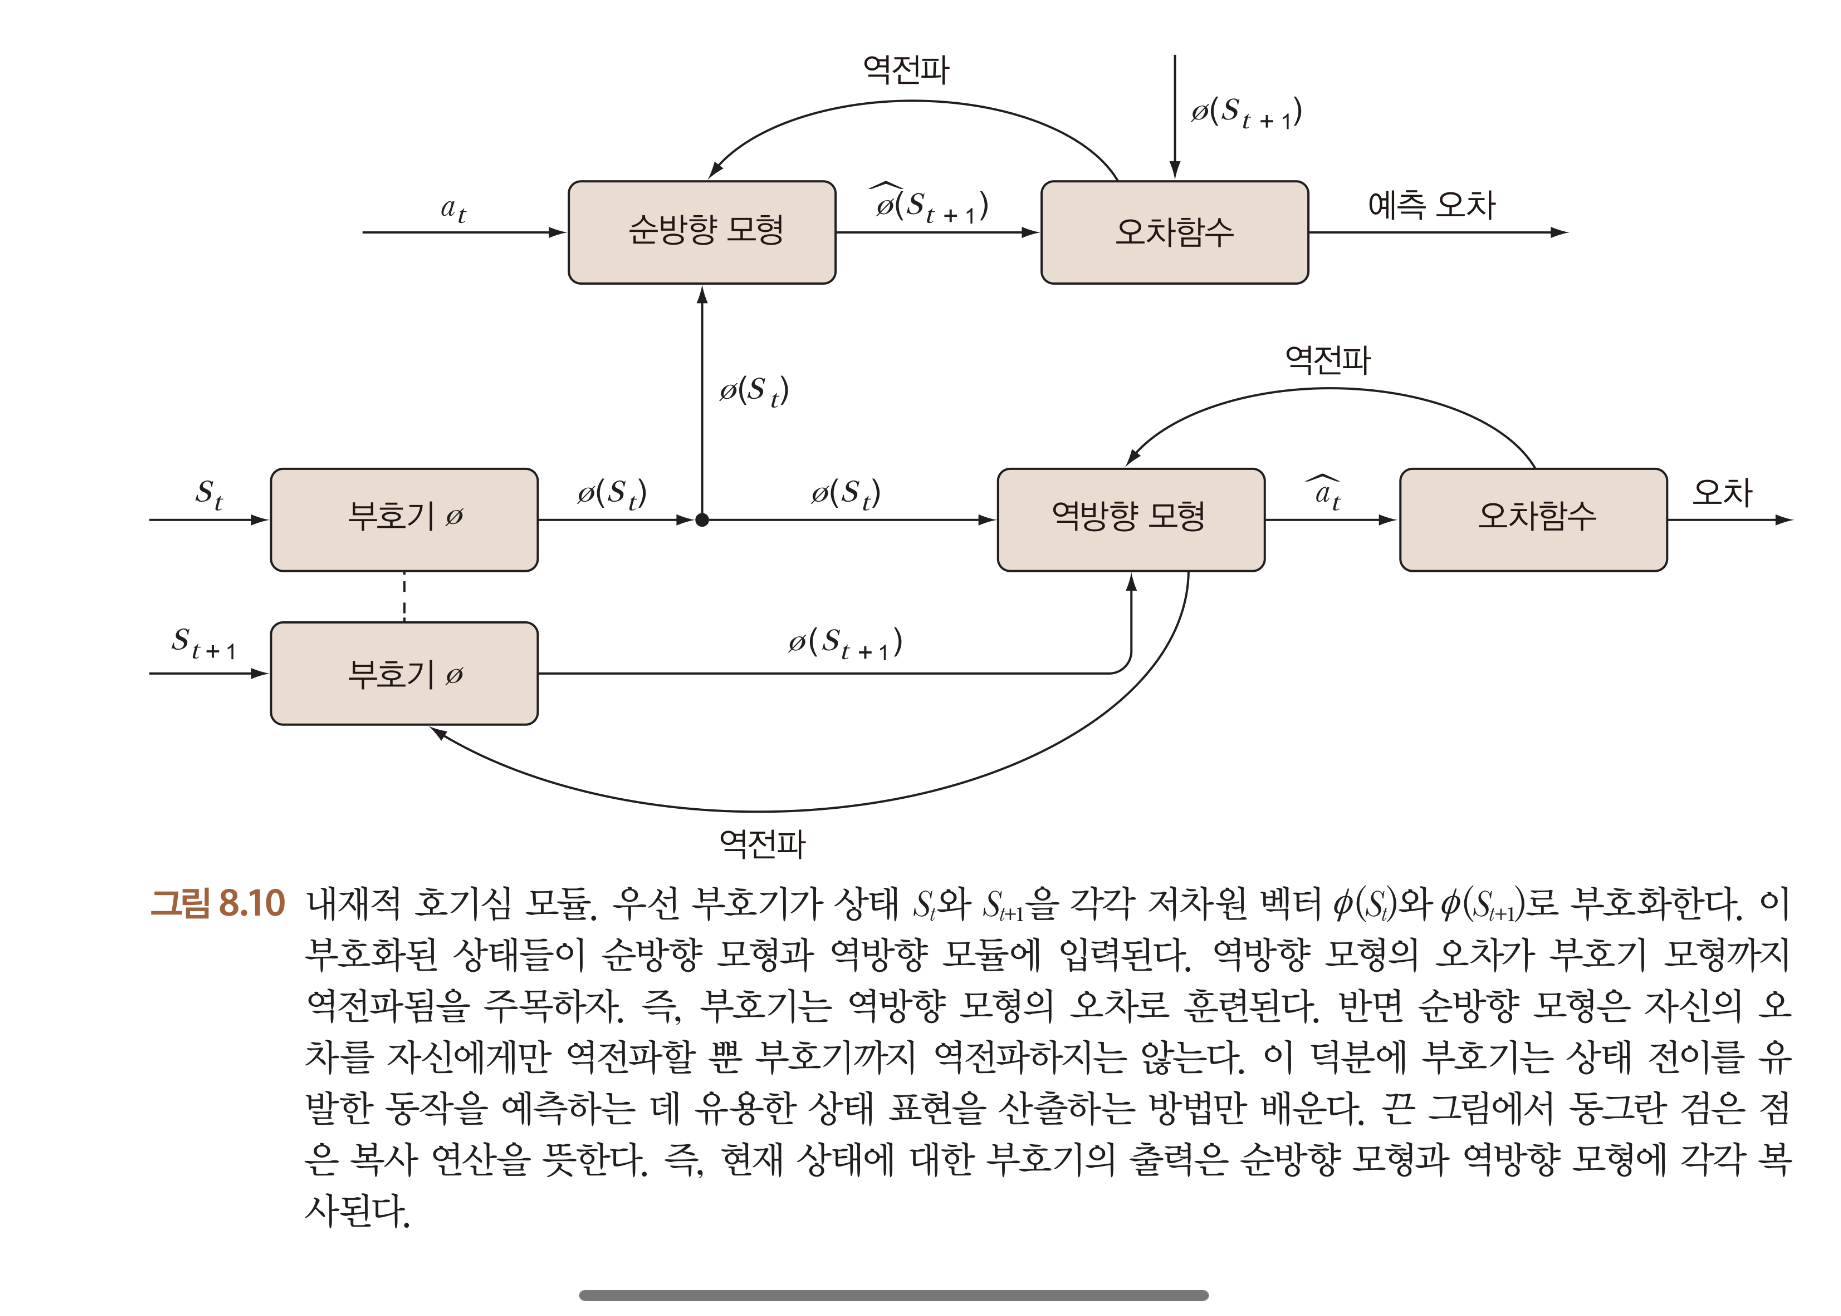

ICM : 내재적 호기심 모듈 (intrinsic curiosity module)  
- 에이전트가 호기심을 가지고 환경을 탐험하게 만드는 내재적 보상 산출  
- 새로운 내재적 보상신호 산출, 모든 에이전트 모형에 사용 가능하고 희소보상에 유용  
슈퍼마리오 : 외재적 보상신호 Off 가능  
- action space (키조합을 통한 12가지)  

##### Listing 8.1

reward, info  
- https://github.com/Kautenja/gym-super-mario-bros/blob/4c89cf601929733800f70833c7fe62973aecdb08/README.md   
- x_pos  

In [1]:
import gym
from nes_py.wrappers import JoypadSpace #A
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT #B
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) #C

2500 step 이후 close가 제대로 되지 않음

In [2]:
# done = True
# for step in range(2500): #D
#     if done:
#         state = env.reset()
#     state, reward, done, info = env.step(env.action_space.sample())
#     env.render()
# env.close()

##### Listing 8.2

원본 상태 : 240*256*3 차원의 RGS 비디오 프레임  
수정 상태 : 42*42, gray scale 단일 채널  
모델 입력 : 42*42 gray scale 이미지 세 장 (속도:이동정보, 빠르기 파악 위해)  
- 길이가 3인 FIFO 입력  

In [3]:
import matplotlib.pyplot as plt
from skimage.transform import resize #A
import numpy as np

def downscale_obs(obs, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) #B
    else:
        return resize(obs, new_size, anti_aliasing=True)

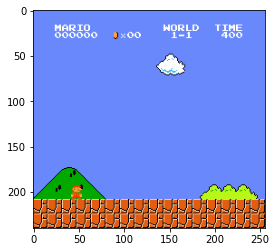

In [4]:
plt.imshow(env.render("rgb_array"))

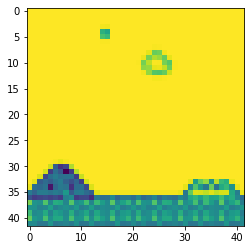

In [5]:
plt.imshow(downscale_obs(env.render("rgb_array")))

##### Listing 8.4

unsqueeze : 배치차원 추가 

In [6]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state): #A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

# state1의 세 프레임 중 제일 오래된 프레임 제거하고 새 프레임(state2 추가)
def prepare_multi_state(state1, state2): #B
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1

# 처음엔 프레임 하나를 3개 복사
def prepare_initial_state(state,N=3): #C
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N,1,1))
    return tmp.unsqueeze(dim=0)

DQN 신경망 
- 입력 : 3*42*42 3개의 gray scale frames  
- 출력 : 12개의 action space에 대한 동작 예측 가치  
- 4개 층의 CNN & 2개 층의 선형층  
- 처음 다섯 층은 ELU 선형함수, 마지막은 활성화 함수 사용하지 않고 원래 값 그대로 이용  
- 마지막층 활성화 함수 쓰지 않음 : 출력이 동작에 대한 가치이므로 보상이 긍정, 부정이냐에 따라서 양수이거나 음수일 수 있기 때문

https://excelsior-cjh.tistory.com/177
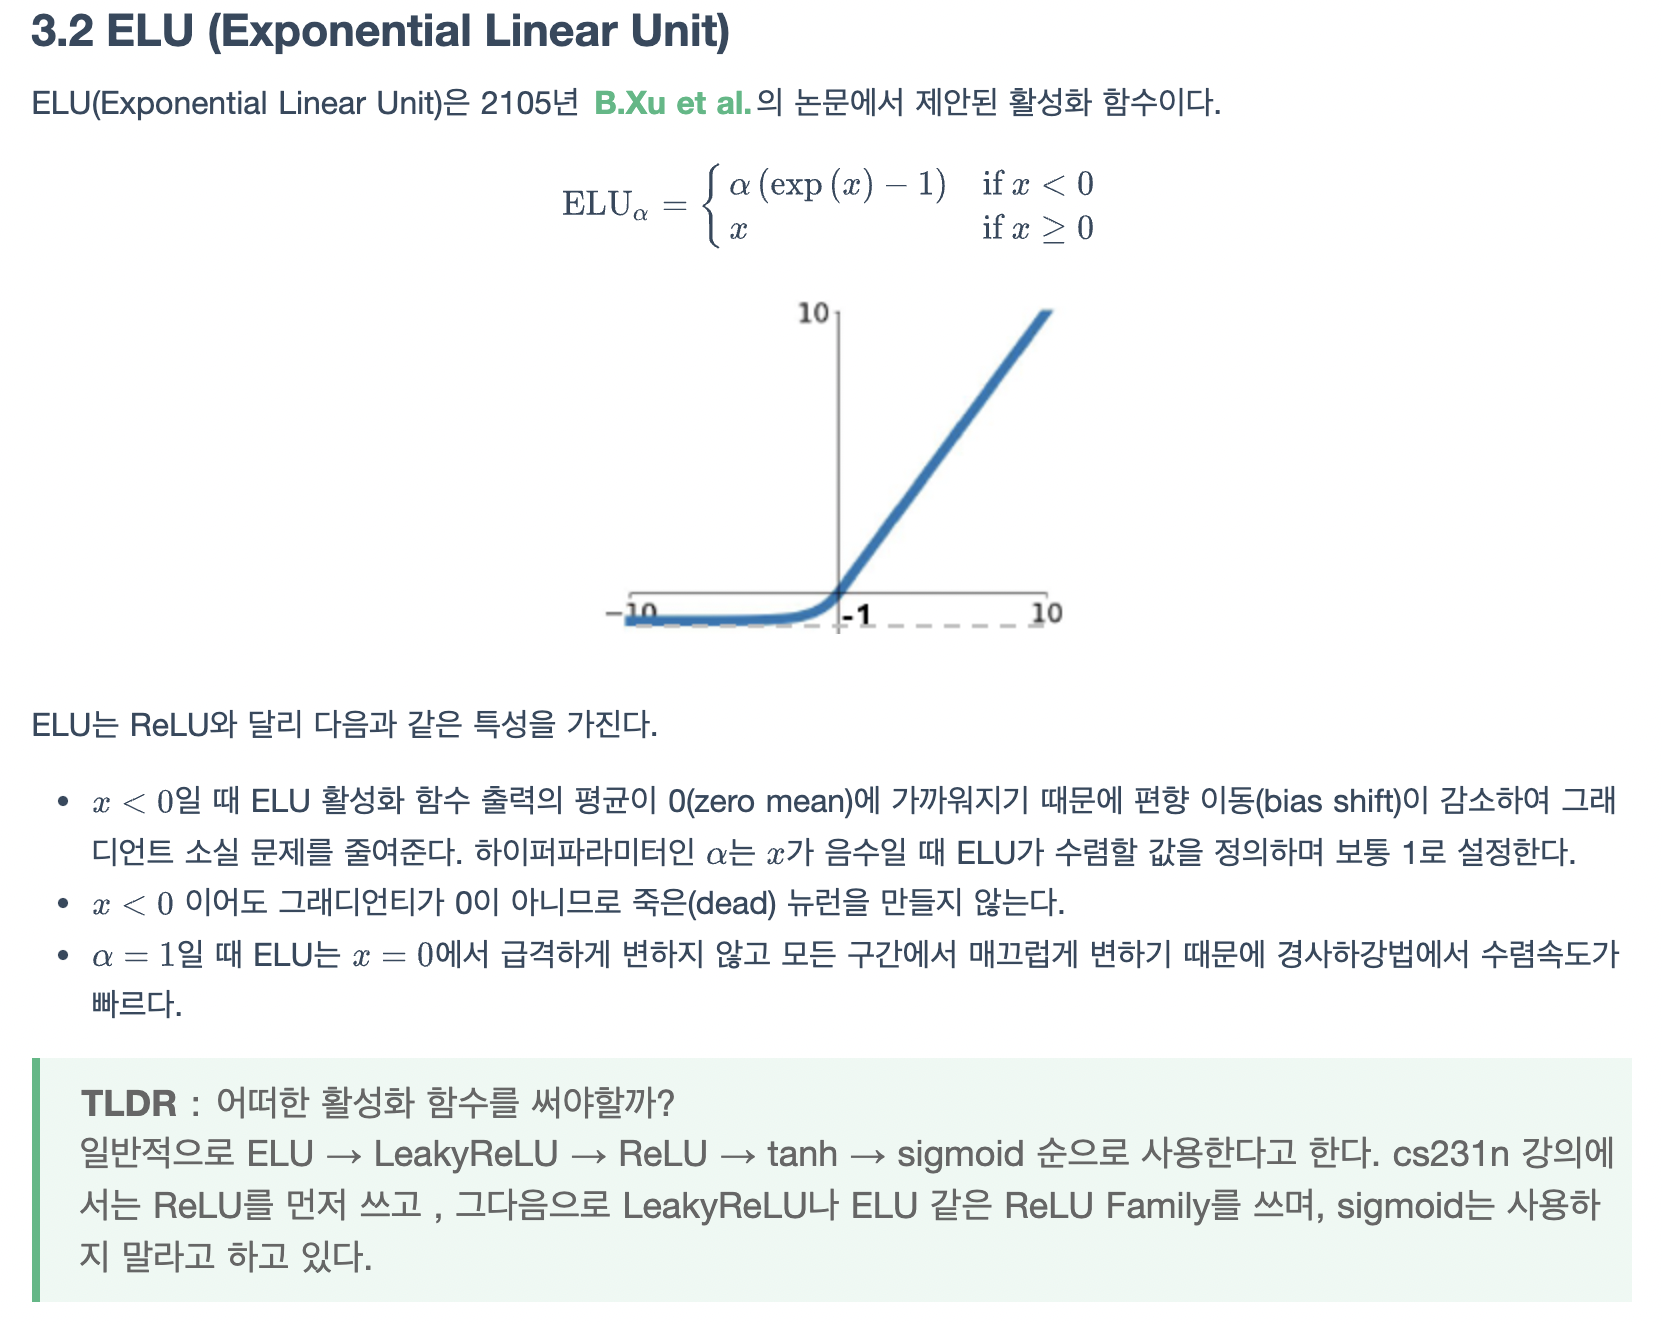

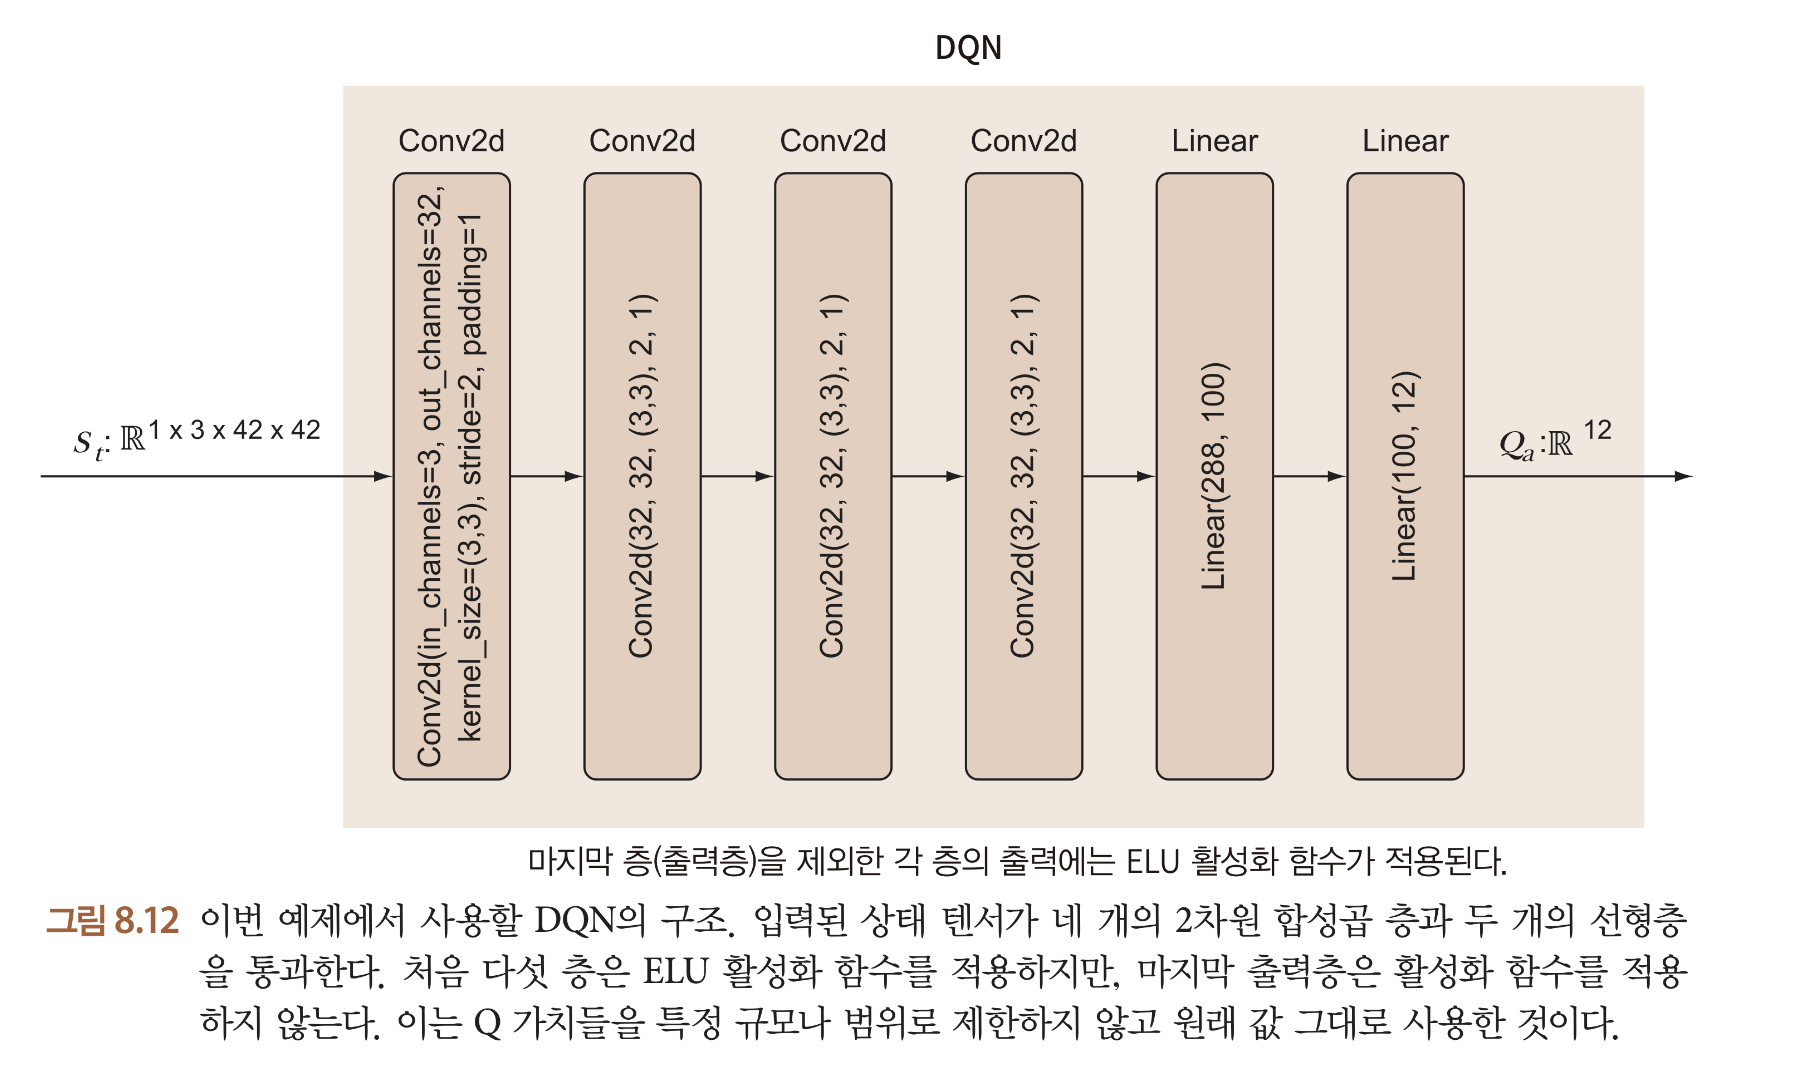

##### Listing 8.5

정책함수  
- softmax만 사용하면 동작 가치 값의 차이가 크지 않을 때 종종 나쁜 경우의 수 선택  
- 처음에 softmax 기반으로 탐험  
- 일정 단계 후에 엡실론 탐욕 전략으로 전환해서 수행하되 최선의 동작 선택(multinomial)    

In [7]:
def policy(qvalues, eps=None): #A
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0,high=7,size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #B

##### Listing 8.6

안정적인 학습을 위해 experience replay 기법 필요  
- 미니 배치 단위 훈련  
- 각 경험 튜플(St, at, rt, St+1)을 목록에 저장

In [8]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N #A 경험 재현목록 크기
        self.batch_size = batch_size #B
        self.memory = [] 
        self.counter = 0
        
    def add_memory(self, state1, action, reward, state2):
        self.counter +=1 
        if self.counter % 500 == 0: #C 경험 500개 추가마다 셔플 - 배치 무작위 추출위해
            self.shuffle_memory()
            
        if len(self.memory) < self.N: #D
            self.memory.append( (state1, action, reward, state2) )
        else: # 500개(버퍼크기) 이상 차면 기존의 임의경험을 새 경험으로 교체
            rand_index = np.random.randint(0,self.N-1)
            self.memory[rand_index] = (state1, action, reward, state2)
    
    def shuffle_memory(self): #E
        shuffle(self.memory)
        
    def get_batch(self): #F
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        #G
        ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False)
        batch = [self.memory[i] for i in ind] #batch is a list of tuples
        # stack : 목록에 담긴 텐서들을 모두 연결해서 하나의 텐서로 만들어줌
        # 스퀴즈(Squeeze) - 1인 차원을 제거
        # 언스퀴즈(Unsqueeze) - 특정 위치에 1인 차원을 추가
        # view(), squeeze(), unsqueeze()는 텐서의 원소 수를 그대로 유지하면서 모양과 차원을 조절
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

ICM(내재적 호기심 모듈)  
- 순방향 모형
- 역방향 모형
- 부호기 모형 

1. 경험 재현 목록에서 B개의 표본을 뽑아서 하나의 배치 구성  
2. B 배치를 ICM과 DQN에 입력  
3. ICM의 예측 오차와 DQN의 오차를 결합해서 전체 오차 구함
4. 전체 오차로 최적화 수행해서 DQN과 ICM 매개변수 갱신 -> DQN이 외재적 보상 뿐만 아니라 내재적 보상까지 반영해서 동작 가치 예측

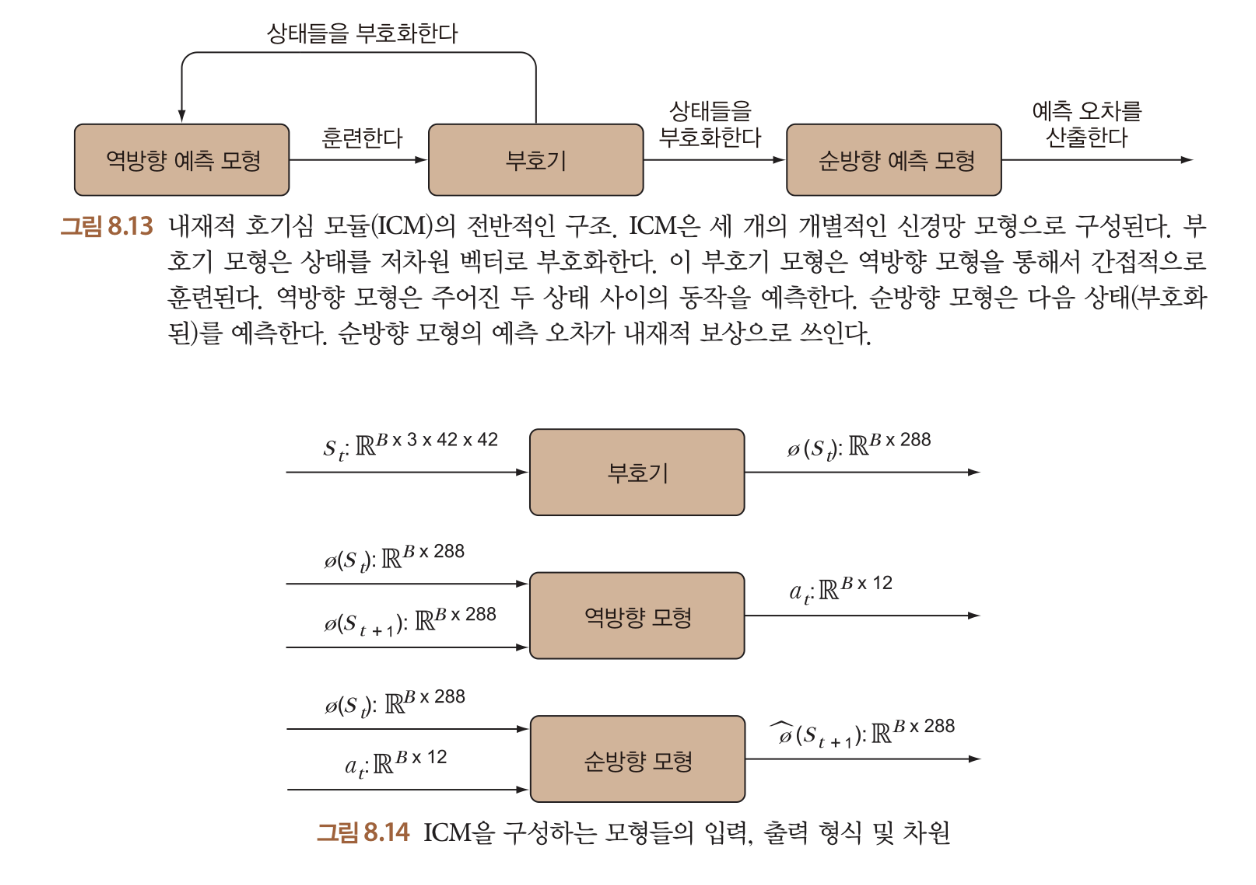

##### Listing 8.7

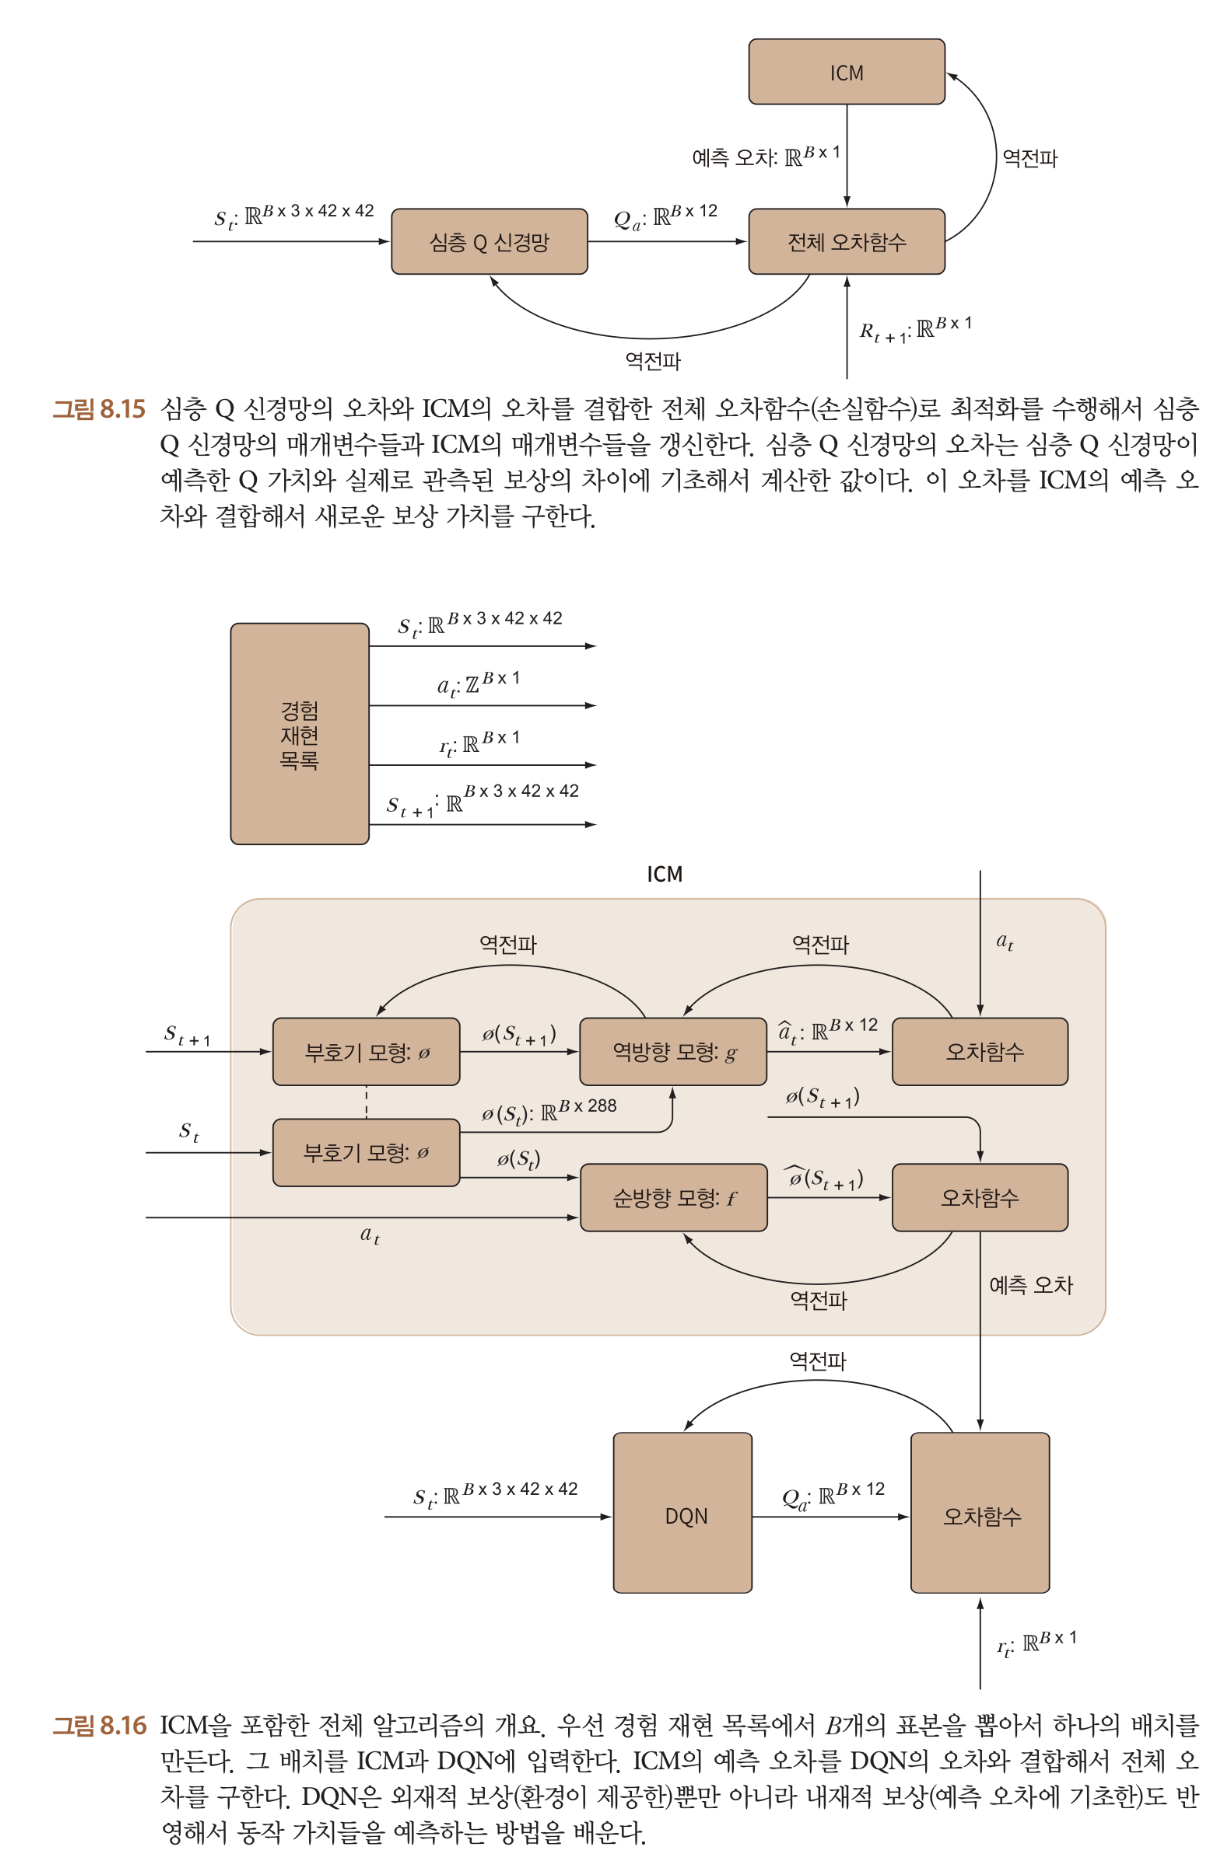

In [9]:
class Phi(nn.Module): #A 부호기 모형 : 원본 프레임 3개를 하나의 저차원 벡터로 변환
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) #size [1, 32, 3, 3] batch, channels, 3 x 3
        y = y.flatten(start_dim=1) #size N, 288
        return y

class Gnet(nn.Module): #B 역방향 모형 : 부호화된 현재, 다음 상태 사이에서 취해진 동작 예측
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576,256) # 288*2 (두 상태)
        self.linear2 = nn.Linear(256,12) # action

    def forward(self, state1,state2):
        x = torch.cat( (state1, state2) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y,dim=1)
        return y

class Fnet(nn.Module): #C 순방향 모형 : 부호화된 현재 상태와 부호화된 다음 상태 예측
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300,256) # (288+12) : 입력 상태(288)와 동작(12: 색인으로 구성) 연결
        self.linear2 = nn.Linear(256,288) # 다음 상태

    def forward(self,state,action):
        action_ = torch.zeros(action.shape[0],12) #D
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat( (state,action_) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

##### Listing 8.8

In [10]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        #in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,12)
        
    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y) #size N, 12
        return y

##### Listing 8.9

In [11]:
params = {
    'batch_size':150,
    'beta':0.2,
    'lambda':0.1,
    'eta': 1.0,
    'gamma':0.2,
    'max_episode_len':100,
    'min_progress':15,
    'action_repeats':6,
    'frames_per_state':3
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) #A 모든 파라미터를 하나로 묶어서 한번에 최적화 
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

##### Listing 8.10
- 전체 손실 : (DQN 손실 + 순방향 손실 + 역방향 손실)의 가중합
- 순방향 손실 : 1-B, 역방향 손실 : B -> 두 합은 1
- 훈련은 전체 손실 값의 최소화 목적으로 진행

In [12]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    return loss

def reset_env():
    """
    Reset the environment and return a new initial state
    """
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
    return state1

##### Listing 8.11

In [13]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1) #A state1, 2 부호화 (저차원)
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) #B 순방향 오차가 역전파 되지 않도록 detach
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, \
                        state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat) #C 12가지 동작들에 대한 소프트맥스 확률분포 돌려줌
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, \
                                        action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

##### Listing 8.12

In [14]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch() 
    action_batch = action_batch.view(action_batch.shape[0],1) #A 입력에 맞게 형태 변환
    reward_batch = reward_batch.view(reward_batch.shape[0],1)
    
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #B ICM 실행
    i_reward = (1. / params['eta']) * forward_pred_err #C 순방향 예측 오차에 비례 계수 Eta 곱함
    reward = i_reward.detach() #D forward 관련 reward 
    if use_extrinsic: #E 
        reward += reward_batch 
    qvals = Qmodel(state2_batch) #F
    reward += params['gamma'] * torch.max(qvals) # gamma : 할인계수
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack( (torch.arange(action_batch.shape[0]), \
    action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

##### Listing 8.13

In [15]:
# import gym
# from nes_py.wrappers import JoypadSpace #A
# import gym_super_mario_bros
# from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT #B
# env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env = JoypadSpace(env, COMPLEX_MOVEMENT) #C

In [ ]:
epochs = 5000
env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))
eps=0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = env.env.env._x_position #A
ep_lengths = []
use_explicit = False
for i in range(epochs):
    if (i%100==0):
        print(i)
    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1) #B
    if i > switch_to_eps_greedy: #C
        action = int(policy(q_val_pred,eps))
    else:
        action = int(policy(q_val_pred))
    for j in range(params['action_repeats']): #D 정책 함수가 선택한 동작을 반복하는 회수 (DQN 동작 가치를 좀 더 빠르게 학습)->훈련과정에서만 사용
        state2, e_reward_, done, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque),dim=1) #E
    replay.add_memory(state1, action, e_reward, state2) #F
    e_reward = 0
    if episode_length > params['max_episode_len']: #G max_episode에서 min_progress 만큼 진행안되면 다시 시작
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = env.env.env._x_position
        episode_length = 0
    else:
        state1 = state2
    if len(replay.memory) < params['batch_size']:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=False) #H
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) #I
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(),\
    inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    loss.backward()
    opt.step()

##### Test Trained Agent

In [ ]:
done = True
state_deque = deque(maxlen=params['frames_per_state'])
try:
    for step in range(5000):
        if done:
            env.reset()
            state1 = prepare_initial_state(env.render('rgb_array'))
        q_val_pred = Qmodel(state1)
        action = int(policy(q_val_pred,eps))
        state2, reward, done, info = env.step(action)
        state2 = prepare_multi_state(state1,state2)
        state1=state2
        env.render()
finally:
    env.close()